# Player Identification MK1 

A kinda full pipeline to player identification 
- Requires massive amounts of ram and system memory 
- 

In [1]:
import torch
import numpy as np
import PIL
from tqdm import tqdm
from PIL import Image
import pytorch_lightning as pl
import segmentation_models_pytorch as smp
from matplotlib import pyplot as plt
import sys  
import os
from pathlib import Path
from matplotlib.pyplot import imshow
from matplotlib import pyplot as plt
import numpy as np

# Set Root Directory to that of LIBRARY
root = Path('/mnt/c/Users/Samarth Negi/Desktop/engine/soccerEye')
sys.path.insert(0, str(root))


from IPython.display import Video
import cv2
import methods 
import utils


## Set up a location for getting dataset videos 

- dataset : location of a folder containing multiple videos

In [2]:
# Set Dataset Path
dataset = Path('../datasets/dfl-bl-video/')
dataset = dataset.resolve()
print(f'Dataset Location : {dataset}')
dataset_files = utils.util_searching_all_files(dataset)
print(f'Number of files in dataset : {len(dataset_files)}')

Dataset Location : /mnt/c/Users/Samarth Negi/Desktop/engine/soccerEye/datasets/dfl-bl-video
Number of files in dataset : 200


In [3]:
videoPick = np.random.randint(len(dataset_files))
print(f'Video Picked (index) : {videoPick}')
cap = cv2.VideoCapture(str(dataset_files[videoPick]))

Video Picked (index) : 16


In [4]:
total_frames = cap.get(7)
print(total_frames)

750.0


## Getting Framelist 

- Since operating on full frames is timetaking, we work only on partial frames (skip frames)
- Skip decides how many frames to skip 

In [5]:
# Get a new framelist skipping n frames
skip = 10

FRAMELIST = []
for framePick in tqdm(range(0,int(total_frames),skip)):
    cap.set(1, framePick)
    ret, frame = cap.read()
    
    img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    im_pil = Image.fromarray(img)

    
    FRAMELIST.append(im_pil)
    

100%|███████████████████████████████████████████████████████████████████████████████████| 75/75 [00:24<00:00,  3.02it/s]


## Field Isolation

In [6]:
OUTFRAMES = methods.P_IF_4_FPN(FRAMELIST,
                      '../weights/FPN_FieldMask_1/checkpoints/epoch=49-step=600.ckpt',
                      inputType='list' )

### Video Fluff Output for Field Isolation

In [7]:
FINAL = []

for ind,FRAME in enumerate(FRAMELIST):
    
    frame_np = np.asarray(FRAME)    
    frame_np_r = cv2.resize(frame_np, (256,256), interpolation = cv2.INTER_AREA)
    
    outframe_normal = cv2.normalize(OUTFRAMES[ind], None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)
    outframe_normal_rgb = cv2.cvtColor(outframe_normal, cv2.COLOR_GRAY2BGR)
    
    final_output = np.concatenate([frame_np_r,outframe_normal_rgb],axis=1)
    
    FINAL.append(final_output)

In [8]:
w = FINAL[0].shape[1]
h = FINAL[0].shape[0]

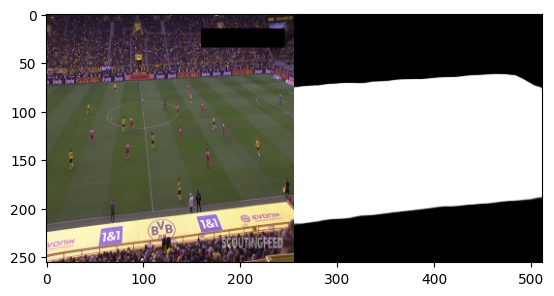

In [9]:
plt.imshow(FINAL[0])

In [10]:
out = cv2.VideoWriter('output.mp4', cv2.VideoWriter_fourcc(*'mp4v'), 10, (w,h))
out = cv2.VideoWriter('output.avi',cv2.VideoWriter_fourcc('M','J','P','G'), 10, (w,h))
for framePick in FINAL:
    out.write(framePick)
    
out.release()

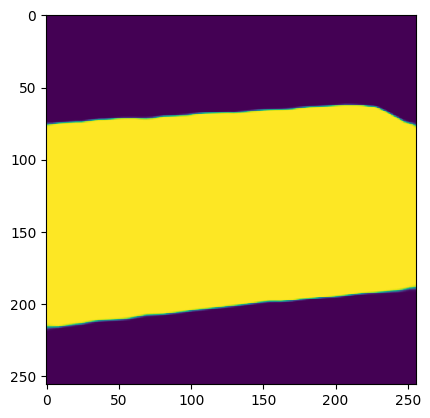

In [11]:
plt.imshow(OUTFRAMES[0])

### Full output for field isolation in Numpy Format

- Creates __`MASKED_FRAMES`__ which containes masked frames

In [12]:
def bin_masks(mask,parameter=0.1):
    # parameter acts sort of like threshold
    
    bins = np.linspace(0, parameter, 2)
    digitized = np.digitize(mask, bins) -1 
    return digitized

In [13]:
# Getting the framelist in numpy 
FRAMELIST_NP = [np.array(x) for x in FRAMELIST]

In [14]:
print('mask shape:',OUTFRAMES[0].shape)
print('original video shape:',FRAMELIST_NP[0].shape)
target_w,target_h,_ = FRAMELIST_NP[0].shape

# Getting the masks in image shape 
OUTFRAMES_RESIZED = [cv2.resize(x, (target_h,target_w), interpolation = cv2.INTER_AREA) for x in OUTFRAMES ]



mask shape: (256, 256)
original video shape: (1080, 1920, 3)


In [15]:
MASKED_FRAMES = []
for index,mask in enumerate(OUTFRAMES_RESIZED):
    binned_mask = bin_masks(mask)
    rgb_mask = np.dstack((binned_mask,binned_mask,binned_mask)).astype(np.uint8)*255
    result = cv2.bitwise_and(FRAMELIST_NP[index], rgb_mask)
    MASKED_FRAMES.append(result)

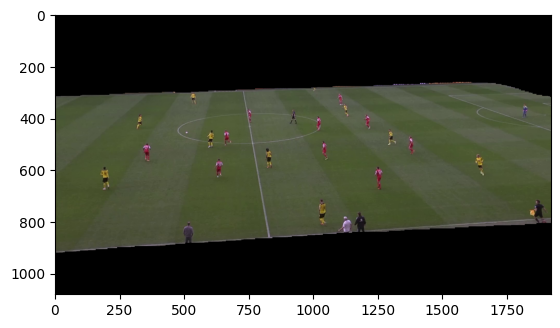

In [16]:
plt.imshow(MASKED_FRAMES[0])

## Player Identification 

In [17]:
import tensorflow as tf
import pathlib
import numpy as np
from PIL import Image
import pandas as pd
import time
from matplotlib import pyplot as plt
import cv2

2022-12-02 15:10:10.090187: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-02 15:10:10.878748: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/tbnc/.local/lib/python3.8/site-packages/cv2/../../lib64:
2022-12-02 15:10:10.878795: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-12-02 15:10:20.470922: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror:

In [18]:
# Load a model 
model_dir = '../weights/player_detection/faster_rcnn_resnet50_v1_640x640_coco17_tpu-8/saved_model/'

In [19]:
model = tf.saved_model.load(str(model_dir))
model_fn = model.signatures['serving_default']

2022-12-02 15:10:25.506312: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/tbnc/.local/lib/python3.8/site-packages/cv2/../../lib64:
2022-12-02 15:10:25.507279: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2022-12-02 15:10:25.507611: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (tbnc-len): /proc/driver/nvidia/version does not exist
2022-12-02 15:10:25.509162: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler f

In [20]:
def detectPersons(image_np,model_fn):
    start = time.time()
    image = np.asarray(image_np)
    input_tensor = tf.convert_to_tensor(image)
    input_tensor = input_tensor[tf.newaxis,...]
    output_dict = model_fn(input_tensor)
    num_detections = int(output_dict.pop('num_detections'))
    output_dict = {key:value[0, :num_detections].numpy() 
                    for key,value in output_dict.items()}
    output_dict['num_detections'] = num_detections
    # detection_classes should be ints.
    output_dict['detection_classes'] = output_dict['detection_classes'].astype(np.int64)
    
    op = {
        'classes':output_dict['detection_classes'].tolist(),
        'boxes':output_dict['detection_boxes'].tolist(),
        'scores':output_dict['detection_scores'].tolist()
    }
    op = pd.DataFrame(op)
    op = op[op['classes']==1]
    end = time.time()
    return op,end-start

In [21]:
def get_normal_coord(decimal_coords,im_height,im_width):
    ymin, xmin, ymax, xmax = decimal_coords
    (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                                  ymin * im_height, ymax * im_height)
    return [int(left),int(right),int(top),int(bottom)]

### Detection for one instance 

In [22]:
image_np = MASKED_FRAMES[0]

In [ ]:
detections, time_taken = detectPersons(image_np,model_fn)

2022-12-02 15:10:40.185164: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 24883200 exceeds 10% of free system memory.


In [ ]:
detections

In [ ]:
im_height,im_width,_ = image_np.shape
left, right, top, bottom = get_normal_coord(detections.iloc[0]['boxes'],im_height,im_width)
image = image_np.copy()

# image = cv2.circle(image, (int(left),int(top)), 10, (255,255,0), 3)
# image = cv2.circle(image, (int(right),int(bottom)), 10, (255,255,0), 3)
image = cv2.rectangle(image, (int(left),int(top)), (int(right),int(bottom)), (0,0,255), 2)
plt.imshow(image)

### Detection for full framelist

In [ ]:
DETECT_FRAME = []
for image_np in tqdm(MASKED_FRAMES):
    detections, time_taken = detectPersons(image_np,model_fn)
    
    detections = detections[detections['scores']>0.10] 
    
    im_height,im_width,_ = image_np.shape
    
    image = image_np.copy()
    
    for index, row in detections.iterrows():
        box = row['boxes'] 
        left, right, top, bottom = get_normal_coord(box,im_height,im_width)
        image = cv2.rectangle(image, (int(left),int(top)), (int(right),int(bottom)), (0,0,255), 2)
    
    DETECT_FRAME.append(image)
    

In [ ]:
plt.imshow(DETECT_FRAME[0])